In [1]:
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
import matplotlib.pyplot as plt
import numpy as np
from src.models import SSA
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    full_params = yaml.safe_load(params_file)
    lfads_params = full_params['lfads_prep']
    analysis_params = full_params['analysis']

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_co = src.lfads_helpers.prep_data_with_lfads(trial_data, 'CO', lfads_params)
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params)

# rebin at larger bin size
td_co = pyaldata.combine_time_bins(td_co, n_bins=int(analysis_params['bin_size']/td_co['bin_size'].values[0]))
td_cst = pyaldata.combine_time_bins(td_cst, n_bins=int(analysis_params['bin_size']/td_cst['bin_size'].values[0]))

td_co = pyaldata.add_gradient(td_co,'lfads_pca',normalize=True)
td_cst = pyaldata.add_gradient(td_cst,'lfads_pca',normalize=True)
td_co = pyaldata.add_gradient(td_co,'M1_pca',normalize=True)
td_cst = pyaldata.add_gradient(td_cst,'M1_pca',normalize=True)

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=5.0,
)
td_co = pyaldata.restrict_to_interval(td_co,epoch_fun=co_epoch_fun)
td_cst = pyaldata.restrict_to_interval(td_cst,epoch_fun=cst_epoch_fun)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  33  34  36  56  62  66  86  92  94  95 103
 110 112 115 120 123 131 137 139 146 157 159 161 162 165 173 181 187 200
 218 222 224 225 229 230 237 239 244 249 254 261 266 269 271 281 286 304
 306 308 309 316 321 334 338 342 344 347 351 352 355 357 360 361 366 369
 370 371 373 376 378 381 382 384 386 388 393 394 399 403 404 405 408 409
 411 413 416 420 422 423 424 426 427 428 429 431 435 436 437 446 447 452
 454 456 458 459 460 461 462 464 469 472 476 477 481 488 489 490 491 492
 494 500 508 509 510 512 513 516 519 534 535 536]
/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more inf

In [3]:
def calc_neural_tangling(x,dx,num_neighbors=None,const_norm=True,take_max=False):
    norm_adjust = 1e-6 if const_norm else 0.1*sum(x.var())
    
    if num_neighbors is None:
        full_tang = pdist(dx,metric='sqeuclidean')/(pdist(x,metric='sqeuclidean')+norm_adjust)
        q = squareform(full_tang).max(axis=1) if take_max else np.percentile(squareform(full_tang),99,axis=1)
    else:
        raise NotImplementedError

    return q


In [26]:
td_co = src.data.add_trial_time(td_co,ref_event='idx_goCueTime')
df_co = src.util.crystallize_dataframe(td_co,sigs=['trialtime','M1_pca','dM1_pca','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel'])
meta_co = src.util.extract_metaframe(td_co,metacols=['trial_id','tgtDir','tgtMag'])
df_co = df_co.join(meta_co,on='trial_id')
df_co['Smoothed Tangling'] = calc_neural_tangling(df_co['M1_pca'],df_co['dM1_pca'])
df_co['LFADS Tangling'] = calc_neural_tangling(df_co['lfads_pca'],df_co['dlfads_pca'])
df_co['LFADS input norm'] = np.linalg.norm(df_co['lfads_inputs'],axis=1)
df_co['X hand position'] = df_co[('rel_hand_pos',0)]
df_co['X hand velocity'] = df_co[('hand_vel',0)]

In [29]:
from ipywidgets import interact
@interact(co_trial_id=list(df_co.groupby('trial_id').groups.keys()))
def plot_trials(co_trial_id):
    trial = df_co.groupby('trial_id').get_group(co_trial_id)

    x_vars = ['trialtime']
    y_vars = ['Smoothed Tangling','LFADS Tangling','LFADS input norm','X hand position','X hand velocity']
    g=sns.PairGrid(
        trial.droplevel(axis=1,level=1)[x_vars+y_vars],
        y_vars=y_vars,
        x_vars=x_vars,
        height=1,
        aspect=4,
    )

    g.map(sns.lineplot)

    for ax in g.axes.flatten():
        ax.plot([0,0],ax.get_ylim(),'k--')

    sns.despine(fig=g.figure,trim=True)


interactive(children=(Dropdown(description='co_trial_id', options=(11, 16, 17, 23, 40, 45, 47, 58, 59, 65, 69,…

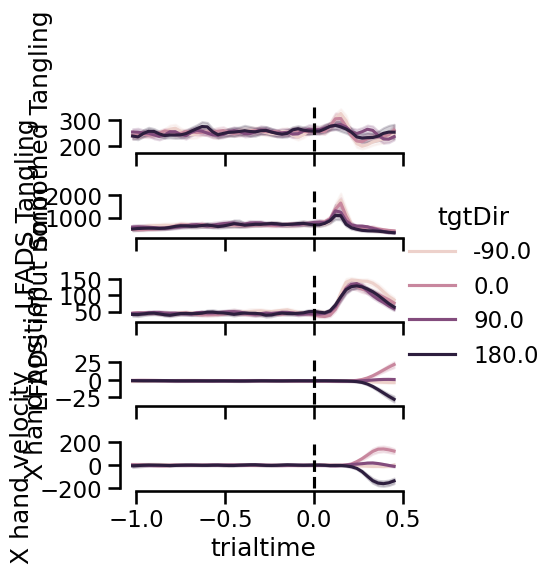

In [32]:
x_vars = ['trialtime']
y_vars = ['Smoothed Tangling','LFADS Tangling','LFADS input norm','X hand position','X hand velocity']
hue_var = 'tgtDir'
g=sns.PairGrid(
    df_co.droplevel(axis=1,level=1)[x_vars+y_vars+[hue_var]],
    y_vars=y_vars,
    x_vars=x_vars,
    hue=hue_var,
    height=1,
    aspect=4,
)

g.map(sns.lineplot)
g.add_legend()

for ax in g.axes.flatten():
    ax.plot([0,0],ax.get_ylim(),'k--')

sns.despine(fig=g.figure,trim=True)


In [33]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
df_cst = src.util.crystallize_dataframe(td_cst,sigs=['trialtime','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel','rel_cursor_pos','cursor_vel'])
df_cst['LFADS input norm'] = np.linalg.norm(df_cst['lfads_inputs'],axis=1)
df_cst['X hand position'] = df_cst[('rel_hand_pos',0)]
df_cst['X hand velocity'] = df_cst[('hand_vel',0)]

In [36]:
@interact(cst_trial_id=list(df_cst.groupby('trial_id').groups.keys()))
def plot_trials(cst_trial_id):
    trial = df_cst.groupby('trial_id').get_group(cst_trial_id)
    x_vars = ['trialtime']
    y_vars = ['LFADS input norm','X hand position','X hand velocity']
    g=sns.PairGrid(
        trial.droplevel(axis=1,level=1)[x_vars+y_vars],
        y_vars=y_vars,
        x_vars=x_vars,
        height=2,
        aspect=4,
    )

    g.map(sns.lineplot)

    for ax in g.axes.flatten():
        ax.plot([0,0],ax.get_ylim(),'k--')

    sns.despine(fig=g.figure,trim=True)

interactive(children=(Dropdown(description='cst_trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 2…

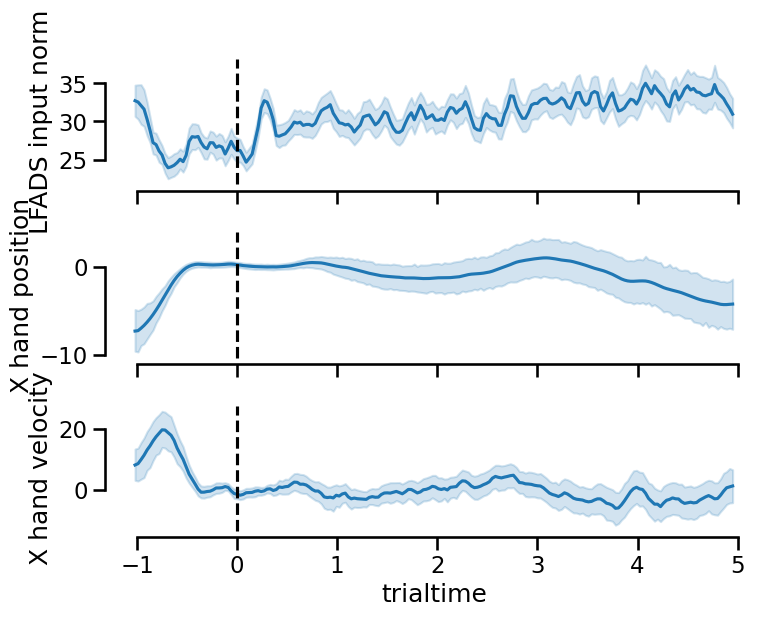

In [38]:
# fig,axs = plt.subplots(3,1,figsize=(8,8),sharex=True)
# # sns.lineplot(
# #     ax=axs[0],
# #     data=df_cst,
# #     x=('trialtime',0),
# #     y='Tangling',
# # )
# sns.lineplot(
#     ax=axs[1],
#     data=df_cst,
#     x=('trialtime',0),
#     y='LFADS input norm',
# )
# sns.lineplot(
#     ax=axs[2],
#     data=df_cst,
#     x=('trialtime',0),
#     y=('rel_hand_pos',0),
# )
# for ax in axs:
#     # TODO: make the go cue dash depend on the chosen bin size
#     ax.plot([0,0],ax.get_ylim(),'k--')
# sns.despine(fig=fig,trim=True)

x_vars = ['trialtime']
y_vars = ['LFADS input norm','X hand position','X hand velocity']
g=sns.PairGrid(
    df_cst.droplevel(axis=1,level=1)[x_vars+y_vars],
    y_vars=y_vars,
    x_vars=x_vars,
    height=2,
    aspect=4,
)

g.map(sns.lineplot)

for ax in g.axes.flatten():
    ax.plot([0,0],ax.get_ylim(),'k--')

sns.despine(fig=g.figure,trim=True)